# EDA Rápido – Serie Uso del Dinero (Punto 3)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("../data/raw/Punto3.SerieUsodeldinero.csv")
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')

df.head()

,fecha,valor_total,valor_total_millones,valor_total_millones_div5
0,2022-07-01,5.587159e+10,55871.592578,11174.318516
1,2022-07-02,1.056773e+10,10567.733300,2113.546660
2,2022-07-03,1.047493e+08,104.749304,20.949861
3,2022-07-05,3.409717e+10,34097.174855,6819.434971
4,2022-07-06,4.072937e+10,40729.368277,8145.873655


In [3]:
df.describe()

,fecha,valor_total,valor_total_millones,valor_total_millones_div5
count,110,1.100000e+02,110.000000,110.000000
mean,2022-09-01 10:41:27.272727296,2.979601e+10,29796.010920,5959.202184
min,2022-07-01 00:00:00,5.000000e+07,50.000000,10.000000
25%,2022-08-03 06:00:00,3.035745e+10,30357.453489,6071.490698
50%,2022-09-02 12:00:00,3.405657e+10,34056.566715,6811.313343
75%,2022-09-29 18:00:00,3.827064e+10,38270.643644,7654.128729
max,2022-10-31 00:00:00,5.587159e+10,55871.592578,11174.318516
std,NaN,1.361625e+10,13616.252691,2723.250538


- Tenemos datos diarios desde **1 de julio a 31 de octubre 2022** con 110 observaciones.
- Hay **13 dias sin actividad** probablemente los domingos.
- La magnitud esta en millones (posiblemente). El promedio es de 29 millones pero con una **GRAN DISPERSION**

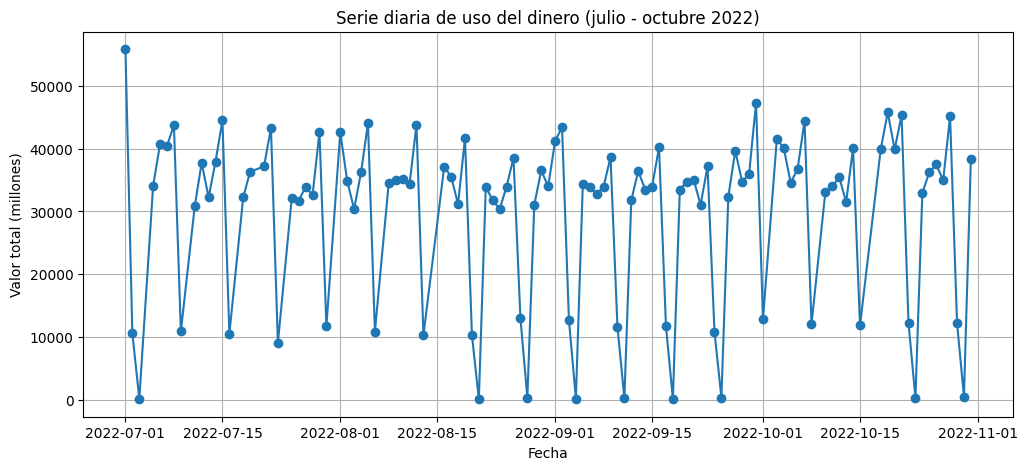

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df['fecha'], df['valor_total_millones'], marker='o', linestyle='-')
plt.title("Serie diaria de uso del dinero (julio - octubre 2022)")
plt.xlabel("Fecha")
plt.ylabel("Valor total (millones)")
plt.grid(True)
plt.show()

- A simple vista, la serie no creo que exista una tendencia marcada creciente o decreciente.
- El comportamiento está dominado por el ciclo semanal.

In [5]:
full_range = pd.date_range(df['fecha'].min(), df['fecha'].max(), freq='D')
missing_days = full_range.difference(df['fecha'])
missing_days, len(missing_days)

(DatetimeIndex(['2022-07-04', '2022-07-10', '2022-07-17', '2022-07-20',
                '2022-07-24', '2022-07-31', '2022-08-07', '2022-08-14',
                '2022-08-15', '2022-10-02', '2022-10-09', '2022-10-16',
                '2022-10-17'],
               dtype='datetime64[ns]', freq=None),
 13)

La mayoria son domingos (10, 17, 24, 31 julio; 7, 14 agosto; 2, 9, 16 octubre).

El 04 y 20 de julio, 15 y 17 de agosto son días hábiles, pero son feriados en USA (¿Tienda de USA?)

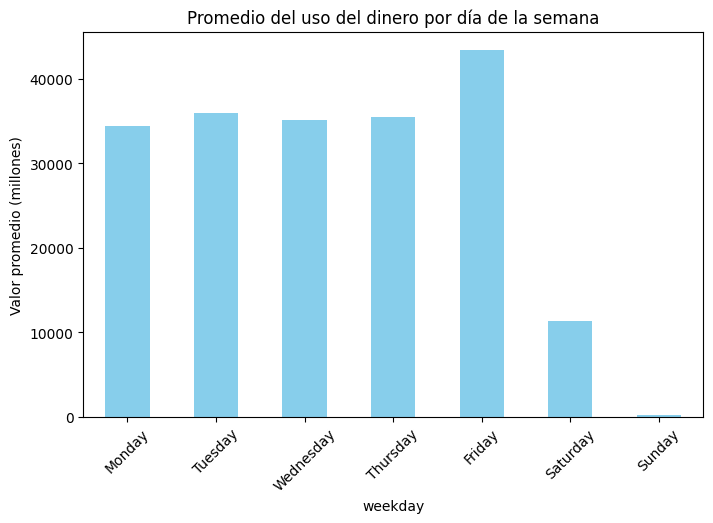

weekday
Monday       34358.677660
Tuesday      35906.862252
Wednesday    35106.597728
Thursday     35484.476705
Friday       43342.661417
Saturday     11375.951869
Sunday         209.741256
Name: valor_total_millones, dtype: float64

In [6]:
df['weekday'] = df['fecha'].dt.day_name()
mean_by_day = df.groupby('weekday')['valor_total_millones'].mean().reindex([
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
])

mean_by_day.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Promedio del uso del dinero por día de la semana")
plt.ylabel("Valor promedio (millones)")
plt.xticks(rotation=45)
plt.show()

mean_by_day

- **Viernes** es el pico más alto (~43.300M).
- **Lunes** a **jueves** rondan entre 34.000M–36.000M.
- **Sábados** bajan drásticamente (~11.300M).
- **Domingos** prácticamente nulos (~200M).

### Análisis para el modelo

- Usar SARIMA con S=7 o Prophet con estacionalidad semanal es obligatorio. La verdad creo que voy a usar **Phrophet** para capturar la **contribución al modelo los fines de semana**

## Limpieza de datos.

In [10]:
# --- Punto 3 · Limpieza y llenado de la serie diaria ---
import pandas as pd
from pathlib import Path

# Paths
ROOT = Path.cwd()  
RAW = "../data/raw/Punto3.SerieUsodeldinero.csv"
from pathlib import Path
CLEAN_DIR = Path("../data/clean")


# 1) Cargar
df = pd.read_csv(RAW)
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values("fecha").reset_index(drop=True)

serie_col = "valor_total_millones"

# 2) Construir rango diario completo y reindexar
full_range = pd.date_range(df["fecha"].min(), df["fecha"].max(), freq="D")
df = df.set_index("fecha").reindex(full_range).rename_axis("fecha").reset_index()

# 3) Identificar domingos y festivos (Colombia)
festivos_col = {
    pd.Timestamp("2022-07-04"),  # Colombia - San Pedro y San Pablo (trasladado a lunes)
    pd.Timestamp("2022-07-20"),  # Colombia - Independencia
    pd.Timestamp("2022-08-15"),  # Colombia - Asunción (trasladado a lunes)
    pd.Timestamp("2022-10-17"),  # Colombia - Día de la Raza (trasladado a lunes)
}
df["weekday"] = df["fecha"].dt.day_name()
df["is_sunday"] = df["fecha"].dt.weekday == 6
df["is_holiday"] = df["fecha"].isin(festivos_col)

# 4) Llenado:
#    - Domingos y festivos: 0 cuando estén NaN (o casi siempre).
#    - Otros NaN (si quedara alguno) → interpolación lineal prudente.
mask_nf = df[serie_col].isna()

# a) Setear 0 en domingos/festivos faltantes
mask_zero = mask_nf & (df["is_sunday"] | df["is_holiday"])
df.loc[mask_zero, serie_col] = 0.0

# b) Interpolar lo restante (no-domingo/feriado)
mask_inter = df[serie_col].isna()
if mask_inter.any():
    df[serie_col] = df[serie_col].interpolate(method="linear", limit_direction="both")

# 5) Reconstruir 'valor_total' (en unidades originales) si la columna existía
if "valor_total" in df.columns:
    df["valor_total"] = (df[serie_col] * 1_000_000).round(0)

# 6) Variables auxiliares útiles para el modelado
df["dow"] = df["fecha"].dt.weekday           # 0=Lun ... 6=Dom
df["is_weekend"] = df["dow"] >= 5

# 7) Chequeo de calidad: no debe haber NaN
assert df[serie_col].isna().sum() == 0, "Aún hay NaN en la serie."

# 8) Guardar limpio
clean_path = CLEAN_DIR / "Punto3.SerieUsodeldinero_clean.csv"
df_out = df[["fecha", serie_col, "valor_total", "dow", "is_weekend", "is_sunday", "is_holiday"]].copy()
df_out.to_csv(clean_path, index=False)

# 9) Splits para modelado (train: jul–sep, test: oct)
train = df_out[(df_out["fecha"] >= "2022-07-01") & (df_out["fecha"] <= "2022-09-30")].copy()
test_oct = df_out[(df_out["fecha"] >= "2022-10-01") & (df_out["fecha"] <= "2022-10-31")].copy()

train.to_csv(CLEAN_DIR / "Punto3.train_jul_sep.csv", index=False)
test_oct.to_csv(CLEAN_DIR / "Punto3.test_oct.csv", index=False)

# 10) (Opcional) dataset en formato Prophet
prophet = df_out.rename(columns={"fecha": "ds", serie_col: "y"})[["ds", "y"]]
prophet.to_csv(CLEAN_DIR / "Punto3.prophet_clean.csv", index=False)

print("✅ Serie limpia guardada en:", clean_path)
print("   Train:", train.shape, "| Test oct:", test_oct.shape)
print("   Prophet file:", (CLEAN_DIR / "Punto3.prophet_clean.csv").name)

✅ Serie limpia guardada en: ../data/clean/Punto3.SerieUsodeldinero_clean.csv
   Train: (92, 7) | Test oct: (31, 7)
   Prophet file: Punto3.prophet_clean.csv
